# Metrics Calculation

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

df = pd.read_csv("../Classification/NER_with_ensemble_sentiment.csv")
df.head()

,id,subreddit,author,score,created_utc,type,num_comments,permalink,title,selftext,...,unique_word_count,ner_text_cleaned,ner_recognized_tickers,ner_entity_sentiments,qwen_sentiments,human1_sentiment,human2_sentiment,ensemble_results,primary_sentiment,primary_score
0,1iy04ol,applestocks,No-Drive8630,2,1740503556,post,3.0,https://www.reddit.com/r/applestocks/comments/...,Buy apple today! ????,Stock is up compared to the market. Board vot...,...,26,Buy AAPL today Stock is up compared to the mar...,AAPL,"{""AAPL"": {""finbert"": {""label"": ""Slightly Posit...",{'AAPL': {'qwen': {'label': 'Positive'}}},{'AAPL': {'human1': {'label': 'Slightly Positi...,"{""AAPL"": {""human2"": {""label"": ""Slightly Positi...","{'AAPL': {'sentiment': 'slightly positive', 's...",slightly positive,0.410751
1,1ixdqih,applestocks,DekeJeffery,2,1740432978,post,1.0,https://www.reddit.com/r/applestocks/comments/...,Apple will spend more than $500 billion in the...,NaN,...,15,AAPL will spend more than 500 billion in the U...,AAPL,"{""AAPL"": {""finbert"": {""label"": ""Neutral"", ""net...",{'AAPL': {'qwen': {'label': 'Positive'}}},{'AAPL': {'human1': {'label': 'Neutral'}}},"{""AAPL"": {""human2"": {""label"": ""Neutral""}}}","{'AAPL': {'sentiment': 'neutral', 'score': 0.0...",neutral,0.000000
2,1iunfst,applestocks,DekeJeffery,3,1740131997,post,1.0,https://www.reddit.com/r/applestocks/comments/...,"AAPL iPhone 16e Built for A.I., Weighing Headw...",NaN,...,10,AAPL AAPL 16e Built for A I Weighing Headwinds...,AAPL,"{""AAPL"": {""finbert"": {""label"": ""Neutral"", ""net...",{'AAPL': {'qwen': {'label': 'Neutral'}}},{'AAPL': {'human1': {'label': 'Neutral'}}},"{""AAPL"": {""human2"": {""label"": ""Neutral""}}}","{'AAPL': {'sentiment': 'neutral', 'score': 0.0...",neutral,0.000000
3,1iu3lir,applestocks,thesatisfiedplethora,0,1740071513,post,2.0,https://www.reddit.com/r/applestocks/comments/...,FAQ For Getting Payment On Apple $490M Investo...,"Hey guys, I posted about this settlement recen...",...,142,FAQ For Getting Payment On AAPL 490M Investor ...,AAPL,"{""AAPL"": {""finbert"": {""label"": ""Neutral"", ""net...",{'AAPL': {'qwen': {'label': 'Neutral'}}},{'AAPL': {'human1': {'label': 'Neutral'}}},"{""AAPL"": {""human2"": {""label"": ""Neutral""}}}","{'AAPL': {'sentiment': 'neutral', 'score': 0.0...",neutral,0.000000
4,1ifidhu,applestocks,goldenson,1,1738449363,post,0.0,https://www.reddit.com/r/applestocks/comments/...,Below is a structured extraction of key highli...,**Below is a structured extraction of key high...,...,393,Below is a structured extraction of key highli...,AAPL,"{""AAPL"": {""finbert"": {""label"": ""Slightly Posit...",{'AAPL': {'qwen': {'label': 'Positive'}}},{'AAPL': {'human1': {'label': 'Slightly Positi...,"{""AAPL"": {""human2"": {""label"": ""Slightly Positi...","{'AAPL': {'sentiment': 'slightly positive', 's...",slightly positive,0.642683


### Process human1, human2

In [2]:
human1_labels = []
human2_labels = []
# Iterate through each row in the dataframe
for _, row in df.iterrows():
    human1_sentiment = row['human1_sentiment']
    human2_sentiment = row['human2_sentiment']
    
    # Skip if either annotation is missing
    if pd.isna(human1_sentiment) or pd.isna(human2_sentiment):
        continue
        
    # Convert string representations to dictionaries if needed
    if isinstance(human1_sentiment, str):
        try:
            human1_sentiment = json.loads(human1_sentiment.replace("'", '"'))
        except:
            continue
            
    if isinstance(human2_sentiment, str):
        try:
            human2_sentiment = json.loads(human2_sentiment.replace("'", '"'))
        except:
            continue
    # Extract company tickers and their corresponding sentiment labels
    for company in human1_sentiment:
        if company in human2_sentiment:
            # Check if both humans provided labels for this company
            if "human1" in human1_sentiment[company] and "human2" in human2_sentiment[company]:
                if "label" in human1_sentiment[company]["human1"] and "label" in human2_sentiment[company]["human2"]:
                    h1_label = human1_sentiment[company]["human1"]["label"]
                    h2_label = human2_sentiment[company]["human2"]["label"]
                    
                    # Add the pair of labels to our lists
                    human1_labels.append(h1_label)
                    human2_labels.append(h2_label)
print(human1_labels[1])
print(human2_labels[1])

Neutral
Neutral


## Inter-Annotator Agreement

Found 1025 valid annotation pairs
Cohen's Kappa Score: 0.8098


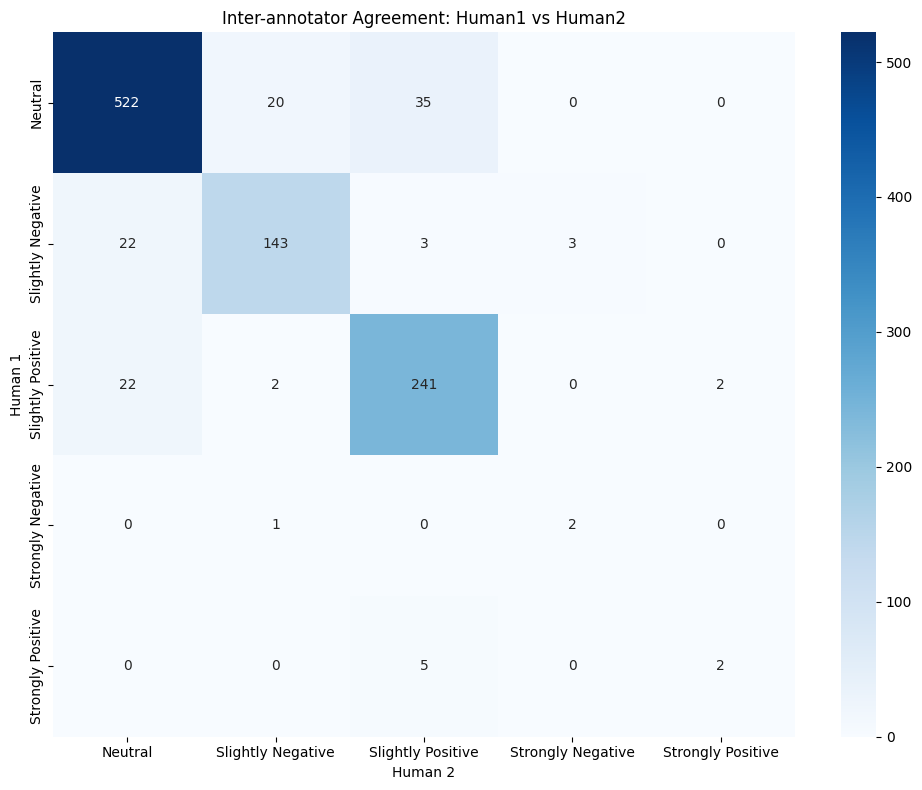

Percentage Agreement: 88.78%


In [3]:
# Print the number of valid pairs found
print(f"Found {len(human1_labels)} valid annotation pairs")

# Calculate Cohen's Kappa
if len(human1_labels) > 0 and len(human2_labels) > 0:
    kappa = cohen_kappa_score(human1_labels, human2_labels)
    print(f"Cohen's Kappa Score: {kappa:.4f}")
    
    # Create a confusion matrix
    matrix = pd.crosstab(
        pd.Series(human1_labels, name='Human 1'),
        pd.Series(human2_labels, name='Human 2')
    )
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Inter-annotator Agreement: Human1 vs Human2')
    plt.tight_layout()
    plt.show()
    
    # Calculate percentage agreement
    matches = sum(1 for h1, h2 in zip(human1_labels, human2_labels) if h1 == h2)
    percent_agreement = (matches / len(human1_labels)) * 100
    print(f"Percentage Agreement: {percent_agreement:.2f}%")

else:
    print("No valid pairs of annotations found")

## Evaluation Metrics

In [9]:
# Lists to store ground truth and predictions
human1_labels = [label.lower() for label in human1_labels]
human2_labels = [label.lower() for label in human2_labels]
primary_sentiment = df["primary_sentiment"]
predictions = primary_sentiment.tolist()

# Store confusion matrices
confusion_matrices = []

# Calculate metrics
def Eval(ground_truth,predictions):
    precision = precision_score(ground_truth, predictions, average='weighted')
    recall = recall_score(ground_truth, predictions, average='weighted')
    fscore = f1_score(ground_truth, predictions, average='weighted')
    accuracy = accuracy_score(ground_truth, predictions)
    return precision, recall, fscore, accuracy

x=0
for i in [human1_labels,human2_labels]:
    x=x+1
    length = len(i)
    resized_predictions = predictions[:length]

    precision, recall, fscore, accuracy = Eval(i,resized_predictions)
    print(f"For Human Label", x)
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F-score: {fscore:.3f}")

    # Calculate and store confusion matrix
    unique_labels = sorted(list(set(i + resized_predictions)))
    cm = confusion_matrix(i, resized_predictions, labels=unique_labels)
    confusion_matrices.append(cm)
    
    # Print confusion matrix
    print(f"Confusion Matrix for Human Label {x}:")
    print(cm)
    print("-------------------")


For Human Label 1
Accuracy: 0.443
Precision: 0.452
Recall: 0.443
F-score: 0.447
Confusion Matrix for Human Label 1:
[[330  87 144   6  10]
 [ 93  36  41   0   1]
 [131  38  87   3   8]
 [  2   0   1   0   0]
 [  4   0   2   0   1]]
-------------------
For Human Label 2
Accuracy: 0.437
Precision: 0.444
Recall: 0.437
F-score: 0.441
Confusion Matrix for Human Label 2:
[[325  82 145   5   9]
 [ 97  31  37   0   1]
 [132  46  92   4  10]
 [  3   1   1   0   0]
 [  3   1   0   0   0]]
-------------------


In [11]:
# Combine confusion matrices by summing them element-wise
combined_confusion_matrix = np.sum(confusion_matrices, axis=0)

print("Combined Confusion Matrix:")
print(combined_confusion_matrix)
print("-------------------")

# Calculate combined precision, recall, and F-score based on the combined confusion matrix
# Extract true positives, false positives, false negatives from the matrix
true_positives = np.diag(combined_confusion_matrix)
false_positives = np.sum(combined_confusion_matrix, axis=0) - true_positives
false_negatives = np.sum(combined_confusion_matrix, axis=1) - true_positives
true_negatives = np.sum(combined_confusion_matrix) - (true_positives + false_positives + false_negatives)

# Calculate precision, recall, and F-score for each class
precision_per_class = true_positives / (true_positives + false_positives + 1e-10)  # Add small value to avoid division by zero
recall_per_class = true_positives / (true_positives + false_negatives + 1e-10)
fscore_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + 1e-10)
accuracy_per_class = (true_positives + true_negatives) / (true_positives + false_positives + false_negatives + true_negatives + 1e-10)

# Calculate weighted averages based on class support
support = np.sum(combined_confusion_matrix, axis=1)  # Number of true instances per class
weighted_precision = np.sum(precision_per_class * support) / np.sum(support)
weighted_recall = np.sum(recall_per_class * support) / np.sum(support)
weighted_fscore = np.sum(fscore_per_class * support) / np.sum(support)
# Calculate overall accuracy (sum of diagonal elements divided by sum of all elements)
weighted_accuracy = np.sum(true_positives) / np.sum(combined_confusion_matrix)

print("Combined Metrics (Weighted):")
print(f"Precision: {weighted_precision:.3f}")
print(f"Recall: {weighted_recall:.3f}")
print(f"F-score: {weighted_fscore:.3f}")
print(f"Accuracy: {weighted_accuracy:.3f}")
print("-------------------")

# Print per-class metrics for more detailed analysis
print("Per-Class Metrics:")
for i, label in enumerate(unique_labels):
    print(f"Class: {label}")
    print(f"  Precision: {precision_per_class[i]:.3f}")
    print(f"  Recall: {recall_per_class[i]:.3f}")
    print(f"  F-score: {fscore_per_class[i]:.3f}")
    print(f"  Accuracy: {accuracy_per_class[i]:.3f}")
    print(f"  Support: {support[i]}")


Combined Confusion Matrix:
[[655 169 289  11  19]
 [190  67  78   0   2]
 [263  84 179   7  18]
 [  5   1   2   0   0]
 [  7   1   2   0   1]]
-------------------
Combined Metrics (Weighted):
Precision: 0.448
Recall: 0.440
F-score: 0.444
Accuracy: 0.440
-------------------
Per-Class Metrics:
Class: neutral
  Precision: 0.585
  Recall: 0.573
  F-score: 0.579
  Accuracy: 0.535
  Support: 1143
Class: slightly negative
  Precision: 0.208
  Recall: 0.199
  F-score: 0.203
  Accuracy: 0.744
  Support: 337
Class: slightly positive
  Precision: 0.325
  Recall: 0.325
  F-score: 0.325
  Accuracy: 0.638
  Support: 551
Class: strongly negative
  Precision: 0.000
  Recall: 0.000
  F-score: 0.000
  Accuracy: 0.987
  Support: 8
Class: strongly positive
  Precision: 0.025
  Recall: 0.091
  F-score: 0.039
  Accuracy: 0.976
  Support: 11


## Random Test

In [ ]:
df_unlabeled = df[pd.isna(df['human1_sentiment']) & pd.isna(df['human2_sentiment'])]

# 1. Randomly assign sentiment labels
sentiment_classes = ["strongly negative", "slightly negative", "neutral", 
                     "slightly positive", "strongly positive"]
random_labels = np.random.choice(sentiment_classes, size=len(df_unlabeled))

# 2. Track error on randomly labeled data
random_accuracy = accuracy_score(random_labels, 
                                df_unlabeled["primary_sentiment"].tolist())

# 3. If random_accuracy is close to 0.2 (1/5 for 5 classes), model is not fitting to noise
print(f"Random Accuracy: {random_accuracy:.3f}")
print(f"Expected Random Accuracy: {1/len(sentiment_classes):.3f}")

Random Accuracy: 0.209
Expected Random Accuracy: 0.200
